In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap, ListedColormap
import seaborn as sns

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=200, n_features=2,
    n_informative=2, n_redundant=0,
    random_state=42
)


data = pd.DataFrame(np.hstack((X, y.reshape(-1, 1))),
                    columns=['x1', 'x2', 'y'])

__Задание 1.__

Обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделяющую поверхность на трейне (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились? (2б)

In [3]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

### Your code is here

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
y_pred_train = dt.predict(X_train)

print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred))

1.0
0.8333333333333334


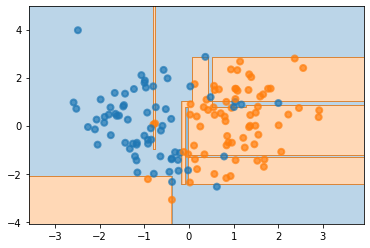

In [6]:
plot_surface(dt, X_train, y_train)

__Задание 2.__

Переберите несколько параметров для регуляризации (`max_depth`, `min_samples_leaf`) из предложенных. Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Используйте, если хотите, функцию ниже. Как изменение параметров влияет на поверхность? При каких параметрах на тесте достигается лучшее качество? А на трейне? (2б).

In [8]:
def plot_surface_axes(clf, X, y, ax, train_acc, test_acc):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
    edgecolors=np.array(palette)[y], linewidths=2)
    
    ax.plot([], [], label = 'train_acc : %0.5f' % train_acc)
    ax.plot([], [], label = 'test_acc : %0.5f' % test_acc)
    
    plt.legend(loc = 'lower right', prop={'size': 20})

In [9]:
max_depth_set = [6, 7, 8, 9, 12]

min_samples_leaf_set = [3, 5, 7, 10]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state = 42) 

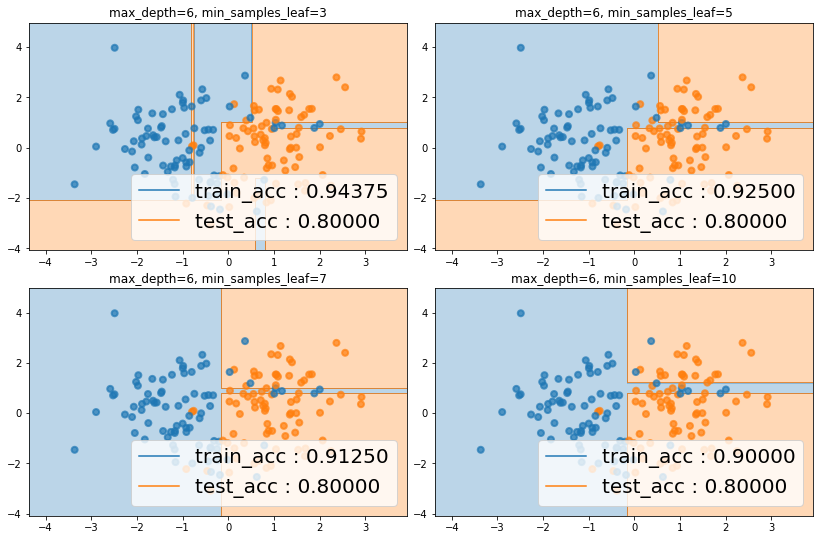

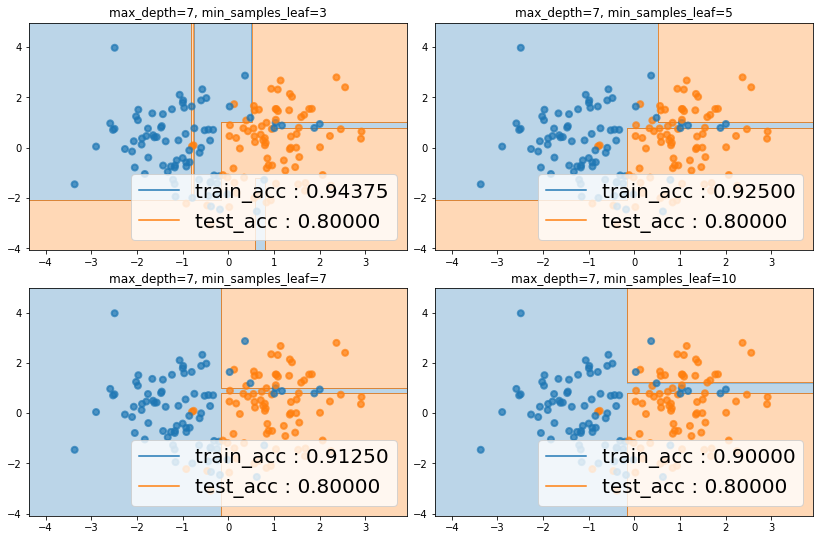

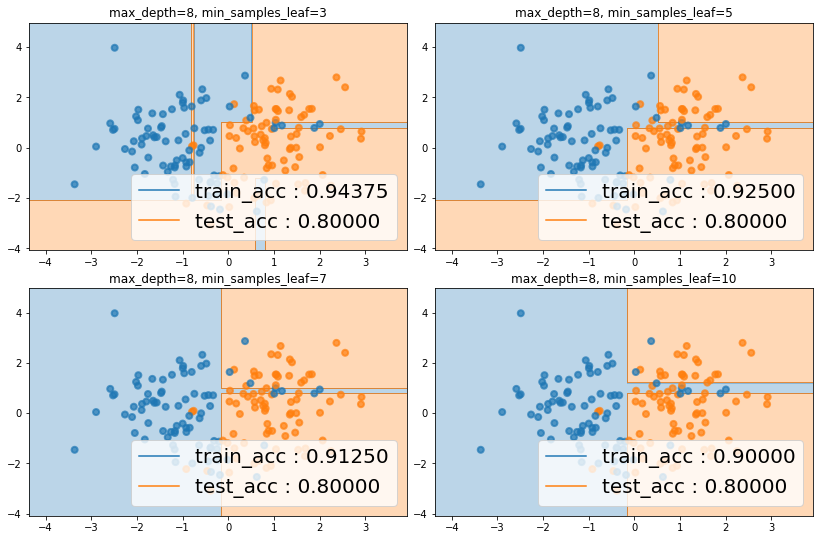

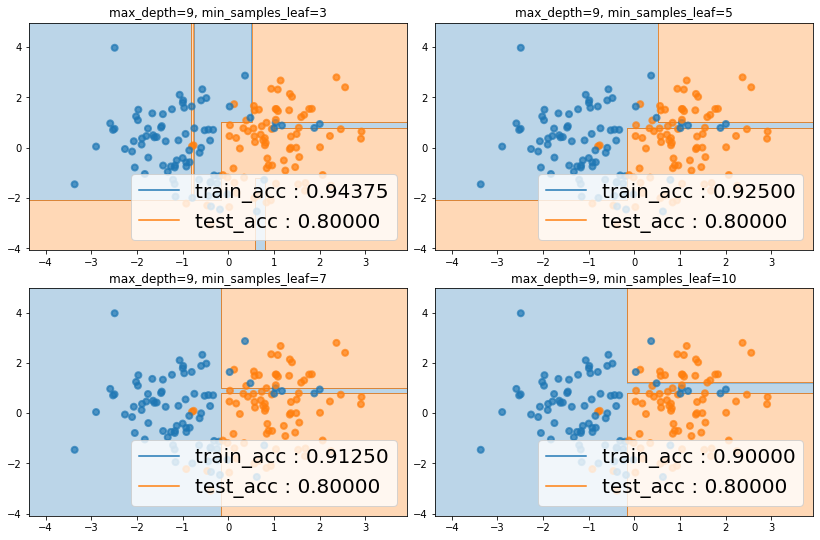

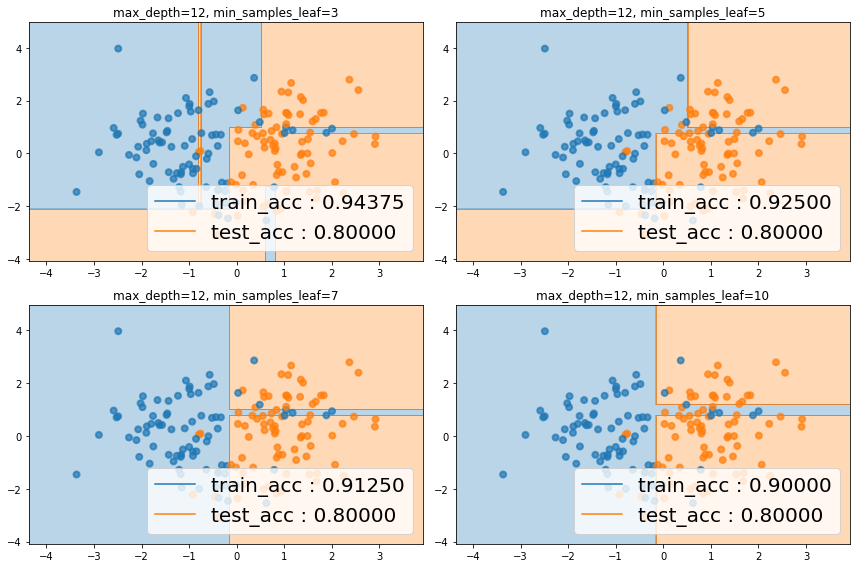

In [20]:
for max_depth in max_depth_set:
    f = plt.figure(figsize=(12, 8))

    for min_samples_leaf in min_samples_leaf_set:
        tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf).fit(X_train, y_train)

        train_acc = tree.score(X_train, y_train)
        test_acc = tree.score(X_test, y_test)

        ax = f.add_subplot(2, 2, min_samples_leaf_set.index(min_samples_leaf) + 1)

        plot_surface_axes(tree, X_train, y_train, ax, train_acc, test_acc)

        ax.set_title(f"max_depth={max_depth}, min_samples_leaf={min_samples_leaf}")

plt.tight_layout()
plt.show();

__Задание 3.__

Добавим признак $2\cdot x_1 - x_2$, транформацию добавим как шаг пайплайна. С помощью данного класса (из практики/лекции) обучите дерево с максимальной глубиной=3, нарисуйте поверхность на трейне, посчитайте accuracy (2 б)

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomFunctionTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, first_col, second_col, function):
        self.first_col = first_col
        self.second_col = second_col
        self.function = function
        print("Инициализировали класс!")
        
    def fit(self, X, y=None):
        print("Зафитили датасет!")
        return self
    
    def transform(self, X, y=None):
        
        X_ = X.copy()
        X_['new_feature'] = self.function(X_[self.first_col], X_[self.second_col])
        X_ = X_.drop([self.first_col, self.second_col], axis=1)
        
        print("Трансформировали датасет!")
        return X_

In [22]:
X_train = pd.DataFrame(X_train, columns=['x1', 'x2'])
X_test = pd.DataFrame(X_test, columns=['x1', 'x2'])

In [24]:
from sklearn.pipeline import Pipeline

### Your code is here

custom_class = CustomFunctionTransformer("x1", "x2",
                                         lambda x,y: 2*x - y)

custom_class.fit(X_train)

custom_class.transform(X_train)



Инициализировали класс!
Зафитили датасет!
Трансформировали датасет!


,new_feature
0,2.096533
1,2.985162
2,-2.472320
3,-1.751586
4,-5.447708
...,...
155,-1.141466
156,2.006015
157,2.753624
158,1.583899


In [25]:
pipe = Pipeline([('custom_class', CustomFunctionTransformer('x1', 'x2', lambda x, y: 2*x - y)), 
                 ('tree', DecisionTreeClassifier(max_depth=3))])

pipe.fit(X_train, y_train)
y_pred_train = pipe.predict(X_train)
y_pred = pipe.predict(X_test)

print(f'Train acc: {accuracy_score(y_train, y_pred_train)}')
print(f'Test acc: {accuracy_score(y_test, y_pred)}')

Инициализировали класс!
Зафитили датасет!
Трансформировали датасет!
Трансформировали датасет!
Трансформировали датасет!
Train acc: 0.8625
Test acc: 0.75


In [30]:
pipe.named_steps['tree']

DecisionTreeClassifier(max_depth=3)

Трансформировали датасет!


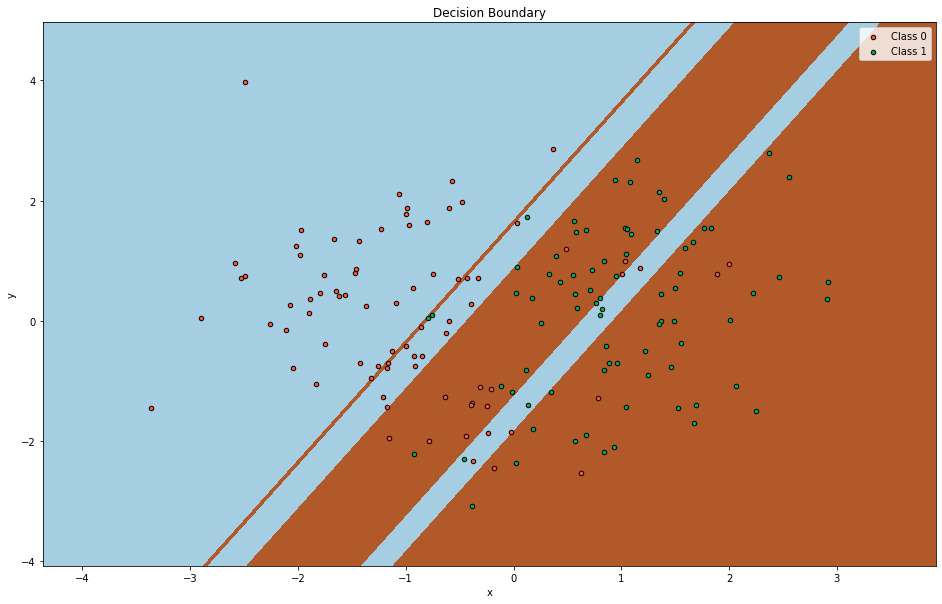

In [35]:
fig = plt.figure()
fig.set_size_inches(16, 10) 

### Вычислим границы признакового пространства

pixel_step = 0.001

x1_min, x1_max = X_train.values[:, 0].min() - 1, X_train.values[:, 0].max() + 1
x2_min, x2_max = X_train.values[:, 1].min() - 1, X_train.values[:, 1].max() + 1

### Генерим много-много точек на плоскости

xx1, xx2 = np.meshgrid(
    np.arange(x1_min, x1_max, pixel_step),
    np.arange(x2_min, x2_max, pixel_step)
)

### Для каждой точки даем прогноз, чтобы покрыть поверхности

Z = pipe.predict(pd.DataFrame(np.c_[xx1.ravel(), xx2.ravel()],
                              columns=["x1", "x2"]))
Z = Z.reshape(xx1.shape)

# Заполняем пространство

cs = plt.contourf(xx1, xx2, Z, cmap=plt.cm.Paired)

plt.axis("tight")

### Рисуем точечки и обученные области

for i, n, c in zip(range(2), pipe.classes_, ["#FF5533", "#00B050"]):
    idx = np.where(y_train == i)
    plt.scatter(
        X_train.values[idx, 0],
        X_train.values[idx, 1],
        c=c,
        s=20,
        edgecolor="k",
        label="Class %s" % n,
    )
    
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.legend(loc="upper right")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Decision Boundary")

plt.show();